In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Setting up the model

In [2]:
# num_hyps is the number of hyperplanes we expect in this example, which fixes the architecture of the network
# If we're not sure what to expect, we would run with a varying number of hyperplanes, to see how many we need to reproduce the data
num_hyps = 2
num_doms = 2*num_hyps
# The below are a set of fixed weights we could impose, which should mirror the structure of mapping the hyperplanes to domains
# However, interestingly, the network seems to train better when those weights are unfixed
hyps_to_doms_params = [
[-3+1/2,2,2],
[-1+1/2,2,-2],
[-1+1/2,-2,2],
[1+1/2,-2,-2]]
# Note that the +1/2 terms mean that a boundary gets contributions from the polynomials on either side

k_input = Input(shape=(2,), name='k_input')
doms_hidden = Dense(units=num_hyps,
        activation='sigmoid', use_bias=False,
        #trainable=False, weights=[temp_array],
        name='doms_hidden')(k_input)
# Layer for mapping the hyperplane conditions to region conditions:
doms_out = Dense(units=num_doms,
        activation='sigmoid',
        #trainable=False, weights=[weights_array, bias_array],
        bias_initializer='ones', name='doms_out')(doms_hidden)

k_quad_input = Input(shape=(6,), name='k_quad_input')
# Layer for mapping [1,k1,k2,k1^2,k1*k2,k2^2] to polynomials for each region:
pols_out = Dense(units=num_doms,
        use_bias=False, name='pols_out')(k_quad_input)

final_pol_out = Dot(axes=1)([doms_out,pols_out])

model = Model(inputs=[k_input,k_quad_input], outputs=[final_pol_out])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 k_input (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 doms_hidden (Dense)            (None, 2)            4           ['k_input[0][0]']                
                                                                                                  
 k_quad_input (InputLayer)      [(None, 6)]          0           []                               
                                                                                                  
 doms_out (Dense)               (None, 4)            12          ['doms_hidden[0][0]']            
                                                                                              

# Training the model

First we read in the data. Note that the part of the network that builds the polynomials takes as input the values [1,k1,k2,k1^2,k1*k2,k2^2], so we create these from the data.

In [3]:
data = pd.read_csv('/kaggle/input/p1xp1-data/p1xp1_data.csv',names=["k1","k2","h0"])

k_list = data.values[:,0:2]
label_list = data.values[:,2]

kquad_list = [None] * len(k_list)
for i in range(len(k_list)):
    k1 = k_list[i,0]
    k2 = k_list[i,1]
    kquad_list[i] = [1,k1,k2,k1**2,k1*k2,k2**2]
    
ks = np.array(k_list)
kquads = np.array(kquad_list)
labels = np.array(label_list)


Training ...


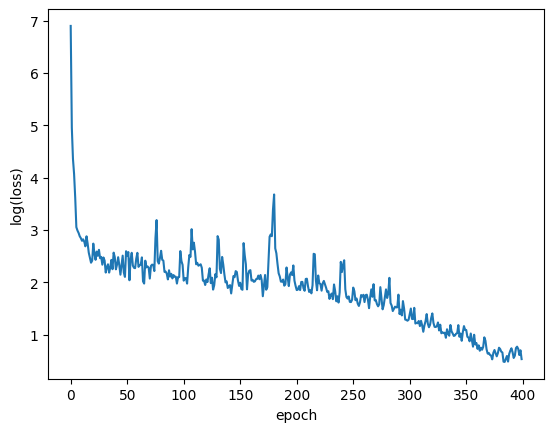

In [4]:
def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.005)
    
callback = LearningRateScheduler(scheduler)

model.compile(optimizer=Adam(learning_rate=.1), loss='mean_squared_error')

print("\nTraining ...")

history = model.fit(x=[ks,kquads], y=labels, batch_size=25, epochs=400, callbacks=[callback], verbose=0)

plt.plot(np.log(history.history['loss']))
plt.ylabel('log(loss)')
plt.xlabel('epoch')
plt.show()

# Visualising the performance

In [5]:
# Functions for visualising the output

def draw_grid(grid, ax, title):
    for (x, y), val in grid.items():
        ax.text(x, y, str(val), ha='center', va='center', fontsize=8, fontweight='bold', color='white')
        ax.plot(x, y, marker='s', markersize=16, color='blue')
    
    ax.set_xlim(-11, 11)
    ax.set_ylim(-11, 11)
    ax.set_xticks(range(-10, 11))
    ax.set_yticks(range(-10, 11))
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_title(title)

def convert_data_to_grid(k_list,label_list):
    grid = {}
    for i in range(len(k_list)):
        x, y = k_list[i]
        val = label_list[i]
        if val != 0:
            grid[(x, y)] = val
    return grid

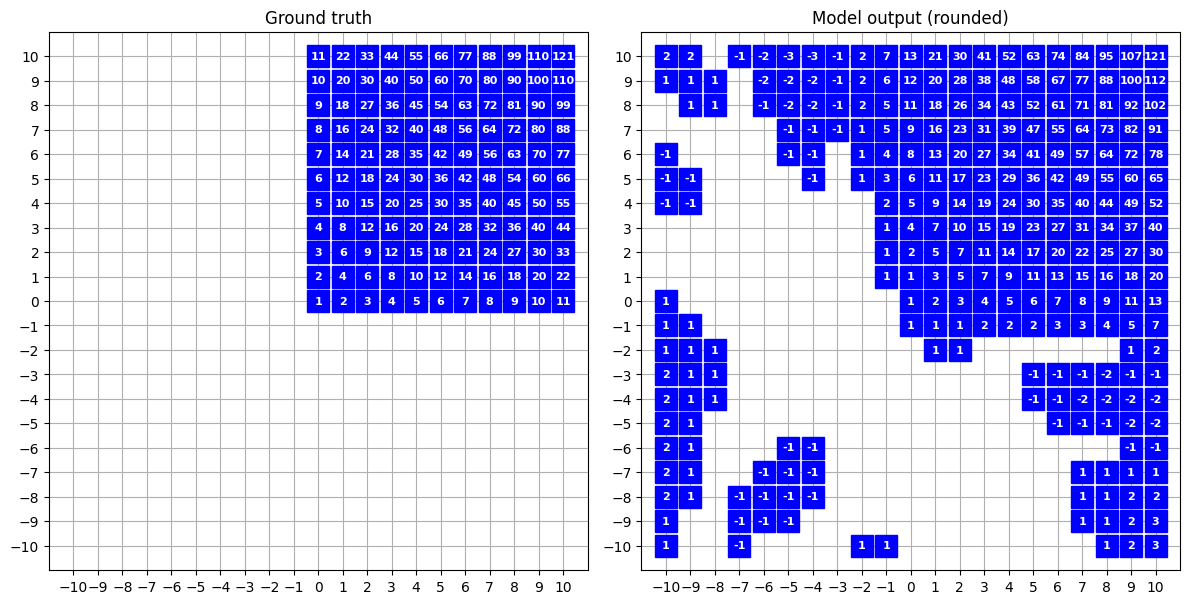

In [6]:
predictions = np.ndarray.flatten(np.rint(model.predict([ks,kquads],verbose=0)).astype(int))

# (It would be nice to add red cell backgrounds for where the output differs from the ground truth)

grid1 = convert_data_to_grid(k_list,label_list)
title1 = "Ground truth"

grid2 = convert_data_to_grid(k_list,predictions)
title2 = "Model output (rounded)"


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

draw_grid(grid1, ax1, title1)
draw_grid(grid2, ax2, title2)

plt.tight_layout()
plt.show()

## Extracting the hyperplanes and polynomials

Below, the hyperplanes are described by the 2x2 array, and the polynomial coefficients by the 6x4 array. The 2x4 array maps the hyperplane conditions to domains, and interestingly differs from what we might have used as fixed weights to represent the domains.

In [7]:
model.weights

[<tf.Variable 'doms_hidden/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.43473536,  0.3849863 ],
        [ 0.35707828,  0.40611213]], dtype=float32)>,
 <tf.Variable 'doms_out/kernel:0' shape=(2, 4) dtype=float32, numpy=
 array([[-4.440537  ,  2.3665442 , -0.17937776,  0.11949117],
        [ 2.8878763 ,  2.8831086 , -1.8430872 ,  2.3648257 ]],
       dtype=float32)>,
 <tf.Variable 'doms_out/bias:0' shape=(4,) dtype=float32, numpy=array([-3.2010057, -5.844793 , -1.6895934, -3.302884 ], dtype=float32)>,
 <tf.Variable 'pols_out/kernel:0' shape=(6, 4) dtype=float32, numpy=
 array([[ 2.359607  ,  1.7633386 ,  9.781853  ,  1.9960885 ],
        [-2.7434006 ,  4.3852863 ,  1.8885504 ,  3.5009184 ],
        [ 5.0292296 ,  1.2532043 ,  1.0897049 ,  2.0637114 ],
        [-0.19569072,  1.8231031 , -0.19201808,  0.33307737],
        [ 0.14249523,  0.292274  ,  0.24140768,  1.0816063 ],
        [ 1.643066  , -0.3638129 , -0.28355327,  0.41222697]],
       dtype=float32)>]